Homework 4

**Keito Watanabe (s6kewata),
Haveesh Singirikonda (s6gusing)**

In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
b = 1   # beta = 1 / kB T

def H(p,q,J,h,N):
    '''Hamiltonian of the long-range Ising model'''
    ham = p**2/2. + q**2/(2*b*J) - N*np.log(2*np.cosh(b*h+q))
    return ham

def p_dot(q,p,J,h,N):
    '''Time derivative of momentum'''
    pd =  q/(b*J) - N*np.tanh(b*h+q)
    return -pd

def q_dot(q,p,J,h,N):
    '''Time derivative of coordinate'''
    return p

def P_acc(p,q,J,h,N):
    '''Acceptance rate'''
    return np.exp(-H(p,q,J,h,N))

In [3]:
N_s = 13300

def leapfrog(N_md,p_0,q_0,J,h,N):
    '''Leapfrog algorithm, iterates for N_md steps with N sites
        given initial variables (p0, q0)
    '''
    dt = 1/N_md   # so that N_md ~ 1
    
    # set variable with initial coordinate
    # and momentum
    p = p_0
    q = q_0
    
    # first step of leapfrog
    # take half step of position
    q = q + 0.5*q_dot(q,p,J,h,N)*dt
    
    # iterate as normal Euler step for 
    # Nmd - 1 steps
    # for Nmd^th step, only perform Euler step for 
    # momentum
    for i in range(N_md):
        p = p + p_dot(q,p,J,h,N)*dt

        if i!=N_md-1:
            q = q + q_dot(q,p,J,h,N)*dt
    
    # perform the last half-step for leapfrog
    q = q + 0.5*q_dot(q,p,J,h,N)*dt
    
    return p,q

In [4]:
def HMC(N_s,N_md,J,h,N, N_cutoff=500):
    '''Hybrid MC, iterates over N_s times with N_md iterations of leapfrog'''
    
    # stores q, p from HMC
    q_mc = np.ones(N_s)
    p_mc = np.ones(N_s)
    
    acc = 0  # for evaluation of acceptance rate
    q_0 = 1.0  # set initial q0 outside sample since we want cts evolution of system
     
    
    for i in tqdm(range(N_s)):
        # sample p0 from a normal distribution for each step
        p_0 = np.random.normal()
        
        # perform leapfrog to get final trajectories
        # for MH step
        p_l,q_l = leapfrog(N_md,p_0,q_0,J,h,N)
        
        # evaluate e^-H(p,q) and e^-H(p0, q0)
        P_0 = P_acc(p_0,q_0,J,h,N)
        P_l = P_acc(p_l,q_l,J,h,N)
        
        # MH step
        r = np.random.normal()
        
        if P_l / P_0 < 1.:  # e^(H(p0, q0) - H(p,q)) < 1
            q_mc[i] = q_l
            p_mc[i] = p_l
            acc += 1
            
        elif P_l/P_0 < r:  # compare with random variable
            q_mc[i] = q_l
            p_mc[i] = p_l
            acc += 1
            
        else:    # rejection step
            q_mc[i] = q_0
            p_mc[i] = p_0  
            
        # set new final points as new initial points
        q_0 = q_mc[i]
        p_0 = p_mc[i]
    
    # remove initial thermalization period
    q_mc = q_mc[N_cutoff:]
    p_mc = p_mc[N_cutoff:]
    
    # acceptance rate is the ratio of accepted over
    # all samples
    R_acc = acc / N_s
    
        
    
    return q_mc, p_mc, R_acc

In [5]:
# setting initial number

b = 1
h = 0.5
N = 5
J = 0.1/N

# the number of leapfrog steps
N_md1 = 100
N_md2 = 4

# resulting final coordinates and acceptance rates
q1_mc,p1_mc,acc1 = HMC(N_s,N_md1,J,h,N)
q2_mc,p2_mc,acc2 = HMC(N_s,N_md2,J,h,N)

# magnetization for each step
m1 = np.tanh(b*h+q1_mc)
m2 = np.tanh(b*h+q2_mc)

100%|█████████████████████████████████████████████████████████████████████████| 13300/13300 [00:00<00:00, 23353.42it/s]


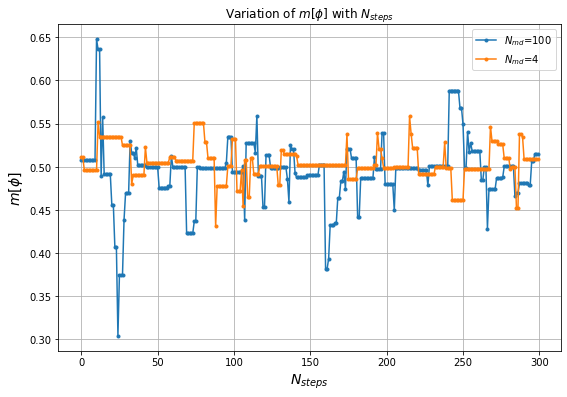

In [6]:
import matplotlib.pyplot as plt

N_steps = 300

step_arr = np.arange(0,N_steps,step=1)

# apply cutoff to see Nsteps number of steps of the iteration
m1_step = m1[:N_steps]
m2_step = m2[:N_steps]

# plot results
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(step_arr, m1_step,label="$N_{{md}}$=100", marker="o", ms=3.0)
ax.plot(step_arr, m2_step,label="$N_{{md}}$=4", marker="o", ms=3.0)

ax.set_xlabel("$N_{{steps}}$", fontsize=14)
ax.set_ylabel("$m[\phi]$", fontsize=14)
ax.set_title("Variation of $m[\phi]$ with $N_{{steps}}$")
ax.legend()
ax.grid()

We can see that there are clear deviations between the two trajectories, however, their differences seem random and a clear dependence on some variable is not observed.

In [7]:
def autocorr(m, tau):
    '''Normalized autocorrelation function'''
    N = len(m)
    mbar = np.mean(m)
    
    gamma_arr = [] 
    
    if tau!= 0:
        for k in range(N-tau):

            l = k + tau

            gamma_arr.append( (m[k] - mbar) * (mbar - m[l]))

            temp_k = l
            temp_l = k

            gamma_arr.append( (m[temp_l] - mbar) * (mbar - m[temp_k]))
            
    if tau==0:
        
        for i in range(N):
            gamma_arr.append( (m[i] - mbar) * (mbar - m[i]))
        
        
    # take the average of gamma_arr
    gamma = np.sum(np.array(gamma_arr)) / len(gamma_arr)
    
    return gamma

In [9]:
N_cutoff = 6000   # must be less than len(m)

tau_arr = np.arange(0,N_cutoff,step=20)
ctau_arr1 = np.zeros(N_cutoff // 20)
ctau_arr2 = np.zeros(N_cutoff // 20)

C0_1 = autocorr(m1, 0)
C0_2 = autocorr(m2, 0)

for i in tqdm(range(len(tau_arr))):
    ctau_arr1[i] = autocorr(m1, tau_arr[i]) 
    ctau_arr2[i] = autocorr(m2, tau_arr[i])
    
    
# divide at the end
ctau_arr1 /= C0_1
ctau_arr2 /= C0_2

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.63it/s]


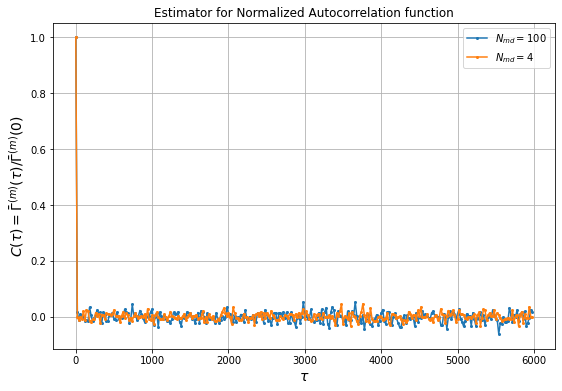

In [10]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr,ctau_arr1,marker='o',label='$N_{md}=100$', ms=2.0)
ax.plot(tau_arr,ctau_arr2,marker='o',label='$N_{md}=4$', ms=2.0)

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function")
ax.grid()
ax.legend()

In [11]:
def binner(m,b):
    '''Bins magnetization according to b'''
    N = len(m)
    
    # if N cannot be divided by bin number
    if N%b != 0:
        return 'Imperfect binning'
    
    # if it can, then perform binning process
    if N%b == 0:
        N_b = int(N/b)
        m_b = np.zeros(N_b)

        for i in range(N_b):
            for j in range(b):
                m_b[i] = m_b[i] + m[i*b+j]
             
    return m_b/b

In [72]:
m_b_2_1 = np.array(binner(m1,2))
m_b_4_1 = np.array(binner(m1,4))
m_b_8_1 = np.array(binner(m1,8))
m_b_16_1 = np.array(binner(m1,16))
m_b_32_1 = (binner(m1,32))
m_b_64_1 = np.array(binner(m1,64))

m_b_2_2 = np.array(binner(m2,2))
m_b_4_2 = np.array(binner(m2,4))
m_b_8_2 = np.array(binner(m2,8))
m_b_16_2 = np.array(binner(m2,16))
m_b_32_2 = (binner(m2,32))
m_b_64_2 = np.array(binner(m2,64))

# np.shape(m1)

In [73]:
tau_arr = np.arange(0,100,step=1)

ctau_arr_2_1 = []
ctau_arr_4_1 = []
ctau_arr_8_1 = []
ctau_arr_16_1 = []
ctau_arr_32_1 = []
ctau_arr_64_1 = []

ctau_arr_2_2 = []
ctau_arr_4_2 = []
ctau_arr_8_2 = []
ctau_arr_16_2 = []
ctau_arr_32_2 = []
ctau_arr_64_2 = []

C0_2_1 = autocorr(m_b_2_1, 0)
C0_4_1 = autocorr(m_b_4_1, 0)
C0_8_1 = autocorr(m_b_8_1, 0)
C0_16_1 = autocorr(m_b_16_1, 0)
C0_32_1 = autocorr(m_b_32_1, 0)
C0_64_1 = autocorr(m_b_64_1, 0)

C0_2_2 = autocorr(m_b_2_2, 0)
C0_4_2 = autocorr(m_b_4_2, 0)
C0_8_2 = autocorr(m_b_8_2, 0)
C0_16_2 = autocorr(m_b_16_2, 0)
C0_32_2 = autocorr(m_b_32_2, 0)
C0_64_2 = autocorr(m_b_64_2, 0)

for tau in tau_arr:
    # for m1
    c_tau_b_2_1 = autocorr(m_b_2_1, tau) / C0_2_1  
    ctau_arr_2_1.append(c_tau_b_2_1)

    c_tau_b_4_1 = autocorr(m_b_4_1, tau) / C0_4_1    
    ctau_arr_4_1.append(c_tau_b_4_1)
    
    c_tau_b_8_1 = autocorr(m_b_8_1, tau) / C0_8_1    
    ctau_arr_8_1.append(c_tau_b_8_1)
    
    c_tau_b_16_1 = autocorr(m_b_16_1, tau) / C0_16_1    
    ctau_arr_16_1.append(c_tau_b_16_1)
    
    c_tau_b_32_1 = autocorr(m_b_32_1, tau) / C0_32_1    
    ctau_arr_32_1.append(c_tau_b_32_1)
    
    c_tau_b_64_1 = autocorr(m_b_64_1, tau) / C0_64_1    
    ctau_arr_64_1.append(c_tau_b_64_1)
    
    # m2
    c_tau_b_2_2 = autocorr(m_b_2_2, tau) / C0_2_2  
    ctau_arr_2_2.append(c_tau_b_2_2)
        
    c_tau_b_4_2 = autocorr(m_b_4_2, tau) / C0_4_2   
    ctau_arr_4_2.append(c_tau_b_4_2)
    
    c_tau_b_8_2 = autocorr(m_b_8_2, tau) / C0_8_2    
    ctau_arr_8_2.append(c_tau_b_8_2)
    
    c_tau_b_16_2 = autocorr(m_b_16_2, tau) / C0_16_2    
    ctau_arr_16_2.append(c_tau_b_16_2)
    
    c_tau_b_32_2 = autocorr(m_b_32_2, tau) / C0_32_2    
    ctau_arr_32_2.append(c_tau_b_32_2)
    
    c_tau_b_64_2 = autocorr(m_b_64_2, tau) / C0_64_2    
    ctau_arr_64_2.append(c_tau_b_64_2)

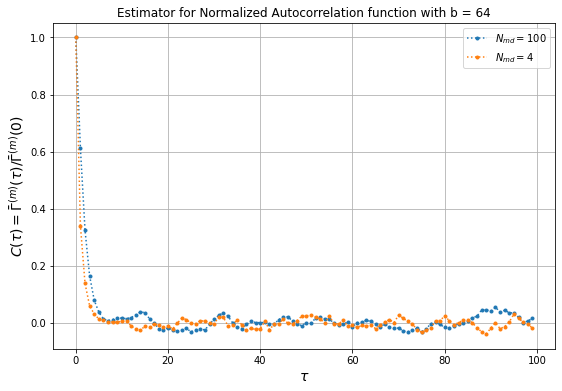

In [75]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr, ctau_arr_2_1, label='$N_{md}=100$', ms=3.0, ls=":", marker="o")
ax.plot(tau_arr, ctau_arr_2_2, label='$N_{md}=4$', ms=3.0, ls=":", marker="o")

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function with b = {0}".format(2))

ax.grid()
ax.legend()

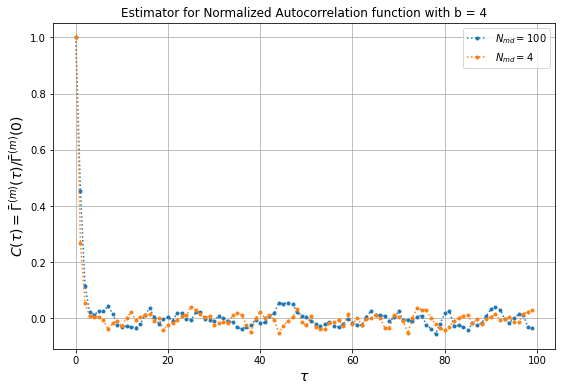

In [76]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr, ctau_arr_4_1, label='$N_{md}=100$', ms=3.0, ls=":", marker="o")
ax.plot(tau_arr, ctau_arr_4_2, label='$N_{md}=4$', ms=3.0, ls=":", marker="o")

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function with b = {0}".format(4))

ax.grid()
ax.legend()

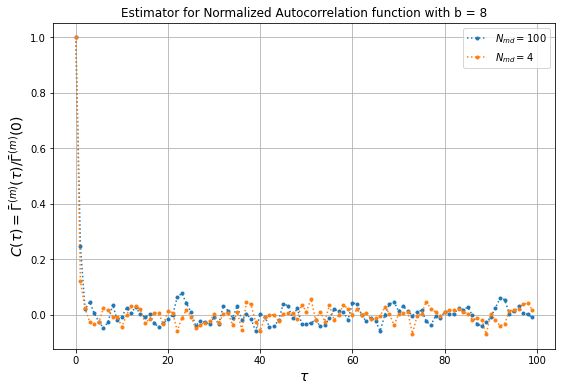

In [77]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr, ctau_arr_8_1, label='$N_{md}=100$', ms=3.0, ls=":", marker="o")
ax.plot(tau_arr, ctau_arr_8_2, label='$N_{md}=4$', ms=3.0, ls=":", marker="o")

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function with b = {0}".format(8))

ax.grid()
ax.legend()

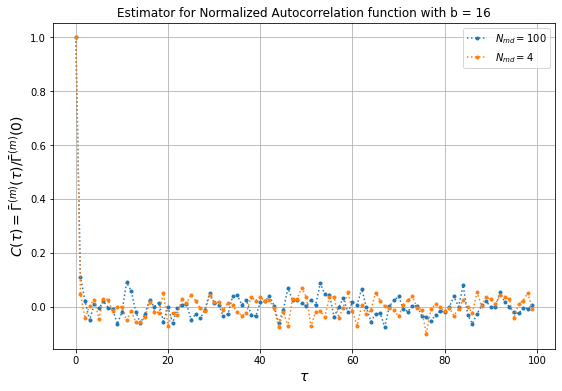

In [78]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr, ctau_arr_16_1, label='$N_{md}=100$', ms=3.0, ls=":", marker="o")
ax.plot(tau_arr, ctau_arr_16_2, label='$N_{md}=4$', ms=3.0, ls=":", marker="o")

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function with b = {0}".format(16))

ax.grid()
ax.legend()

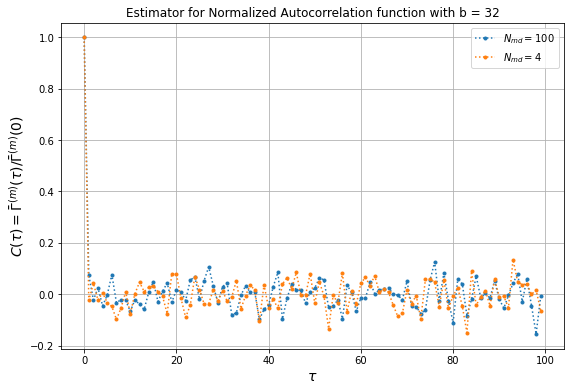

In [79]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr, ctau_arr_32_1, label='$N_{md}=100$', ms=3.0, ls=":", marker="o")
ax.plot(tau_arr, ctau_arr_32_2, label='$N_{md}=4$', ms=3.0, ls=":", marker="o")

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function with b = {0}".format(32))

ax.grid()
ax.legend()

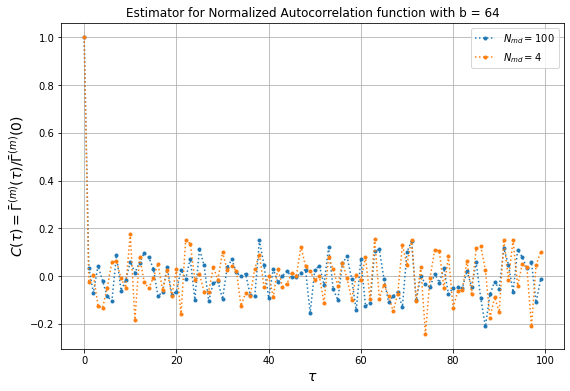

In [80]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(tau_arr, ctau_arr_64_1, label='$N_{md}=100$', ms=3.0, ls=":", marker="o")
ax.plot(tau_arr, ctau_arr_64_2, label='$N_{md}=4$', ms=3.0, ls=":", marker="o")

ax.set_xlabel(r"$\tau$", fontsize=14)
ax.set_ylabel(r"$C(\tau) = \bar\Gamma^{{(m)}}(\tau)   /   \bar\Gamma^{{(m)}}(0)$", fontsize=14)
ax.set_title("Estimator for Normalized Autocorrelation function with b = {0}".format(64))

ax.grid()
ax.legend()

Looking at the autocorrelation plots for different blocked lists, we observe that the deviations increase as the size of the blocked list decreases (which is the same as $b$ increasing). This is not consistent with what we expected as the binning should reduce the autocorrelation of the system.

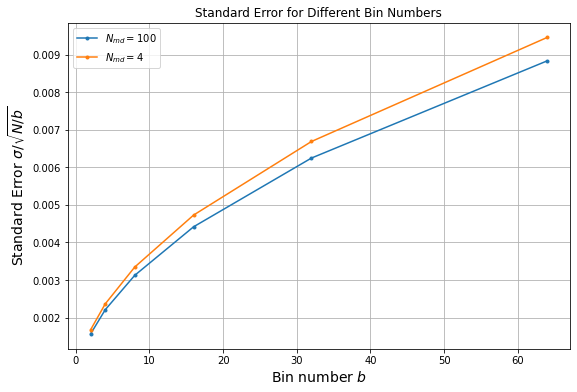

In [85]:
def std_err(arr, N, b):
    '''Naive standard error'''
    return np.std(arr) / np.sqrt(N / b)

b_arr = np.array([2, 4, 8, 16, 32, 64])
std_err_arr1 = []
std_err_arr2 = []

N = m1.size

for i, ctau_arr1 in enumerate(ctaus_arr1):
    std_err_arr1.append(std_err(ctau_arr1, N, b_arr[i]))
    
for i, ctau_arr1 in enumerate(ctaus_arr1):
    std_err_arr2.append(std_err(ctau_arr2, N, b_arr[i]))

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(b_arr, std_err_arr1, marker="o", ms=3.0, label='$N_{md}=100$')
ax.plot(b_arr, std_err_arr2, marker="o", ms=3.0, label='$N_{md}=4$')
ax.set_xlabel("Bin number $b$", fontsize=14)
ax.set_ylabel("Standard Error $\sigma  /  \sqrt{{N   /  b}}$", fontsize=14)
ax.set_title("Standard Error for Different Bin Numbers")

ax.grid()
ax.legend()

We observe that as we increase the bin number $b$, we observe that the standard error increases slowly. This shows that with a large bin number, we are not able to get the optimal binning width to reduce the autocorrelation of the system. This further emphasizes the previous plots where the larger blocking increases the autocorrelation instead of reducing it.

Bootstrapping

We chose $b = 8$ for our blocked list.

In [88]:
N_bs = np.arange(100,2000,step=100)

sigma1 = np.ones(len(N_bs))

N = m_b_8_1.size

for i in tqdm(range(len(N_bs))):
    
    m_mean = np.ones(N_bs[i])
    
    for k in range(N_bs[i]):
        
        r = np.random.randint(0,N-1,size=N)

        m_bs = np.ones(N)

        for j in range(N):

            m_bs[j] = m_b_8_1[r[j]]

        m_mean[k] = np.mean(m_bs)
        
    sigma1[i] = np.sqrt(np.var(m_mean))
    


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.73s/it]


In [89]:
N_bs = np.arange(100,2000,step=100)

sigma2 = np.ones(len(N_bs))

N = m_b_8_2.size

for i in tqdm(range(len(N_bs))):
    
    m_mean = np.ones(N_bs[i])
    
    for k in range(N_bs[i]):
        
        r = np.random.randint(0,N-1,size=N)

        m_bs = np.ones(N)

        for j in range(N):

            m_bs[j] = m_b_8_2[r[j]]

        m_mean[k] = np.mean(m_bs)
        
    sigma2[i] = np.sqrt(np.var(m_mean))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.70s/it]


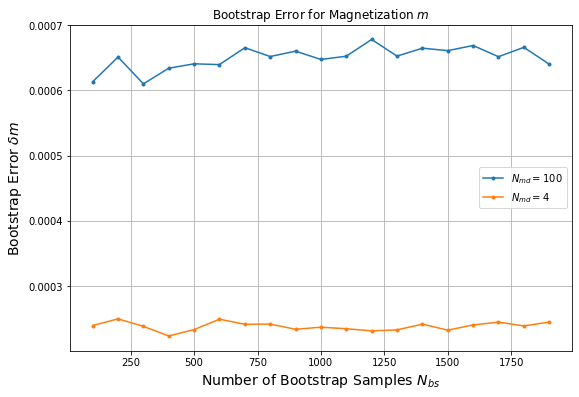

In [90]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(N_bs, sigma1, marker="o", ms=3.0, label='$N_{md}=100$')
ax.plot(N_bs, sigma2, marker="o", ms=3.0, label='$N_{md}=4$')
ax.set_xlabel("Number of Bootstrap Samples $N_{{bs}}$", fontsize=14)
ax.set_ylabel("Bootstrap Error $\delta m$", fontsize=14)
ax.set_title("Bootstrap Error for Magnetization $m$")

ax.grid()
ax.legend()

We see that the stability of the error is fairly consistent with increasing iterations of bootstrap samples. When comparing the bootstrap error to the naive standard error, we observe that even with increasing number of samples, the bootstrap error stays consistent and as such is a better method to perform MC error analysis with.